# Identification of emerging technologies using NLP-powered patent networks

> Author: **Antoine MATHIEU COLLIN**
* Department of Management, Strategy and Innovation (MSI) of the Faculty of Economics and Business (FEB), KU Leuven
* Department of Computer Science of the Faculty of Engineering Science, KU Leuven
* Leuven.AI, KU Leuven Institute for Artificial Intelligence

## Table of contents
- [1. Introduction](#1.-Introduction)
    - [1.1. Configuration](#1.1.-Configuration)
    - [1.2. Data coverage choices](#1.2.-Data-coverage-choices)
- [2. Data](#2.-Data)
    - [2.1 Load data](#2.1-Load-data)
    - [2.2. Data cleaning](#2.2.-Data-cleaning)
- [3. Methodology](#3.-Methodology)
- [3.1 New metrics](#3.1-New-metrics)
    - [3.2 Reshaping to OOP](#3.2-Reshaping-to-OOP)
    - [3.3 Get citations](#3.3-Get-citations)
    - [3.4. Retriving the full text data for the patents of interest](#3.4.-Retriving-the-full-text-data-for-the-patents-of-interest)
    - [3.5. Text processing](#3.5.-Text-processing)
    - [3.6. Building the nlp-based patent network](#3.6.-Building-the-nlp-based-patent-network)
- [4. Results and case study](#4.-Results-and-case-study)
    - [4.1 Summary statistics](#4.1-Summary-statistics)
    - [4.2. Visualisation](#4.2.-Visualisation)
    - [4.3. Core modelling](#4.3.-Core-modelling)
    - [4.4 Computations](#4.4-Computations)
- [5. Concluding remarks](#5.-Concluding-remarks)
- [References](#References)
- [Annex 1 - The Leiden algorithm](#Annex-1---The-Leiden-algorithm)

## 1. Introduction

### 1.1. Configuration

In [29]:
# data wrangling
import pandas as pd
import math
import numpy as np
import igraph
from igraph import Graph

# language processing
import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

# machine learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score

# figures
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

In [30]:
# library to parse the xml content of the EP full text database
# library doc: https://docs.python.org/3/library/xml.etree.elementtree.html
import xml.etree.ElementTree as ET 

In [31]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

### 1.2. Data coverage choices

In [32]:
class Config:
    """Configuration"""
    
    # Magic numbers
    LAST_YEAR_TO_RECEIVE_CITAITONS = 2018
    FIRST_YEAR_CONVERAGE_EP_FULL_TEXT = 2000
    LAST_YEAR_COVERAGE_PATSTAT = 2014
    GRANTED_PATENT_CODE = 1
    PERCENTAGE_TOP_PATENTS = 0.1
    EP_AUTHORITY = 'EP'

    # PASTAT_variables 
    VAR_APPLN_ID = 'appln_id'
    VAR_DOCDC_FAMILY_ID = 'docdb_family_id'
    VAR_CITED_DOCDB_FAM_ID = 'cited_docdb_family_id'
    VAR_APPLN_FILLING_YEAR = 'appln_filing_year'
    VAR_NB_CITING_DOCDB_FAM = 'nb_citing_docdb_fam'
    VAR_EARLIEST_FILLING_DATE = 'earliest_filing_date'
    VAR_EARLIEST_FILING_YEAR = 'earliest_filing_year'

    # Computed variables
    NEW_VAR_CITING_DOCDB_FAM_IDS = 'citing_docdb_families_ids'
    NEW_VAR_NB_CITING_DOCDB_FAM_BY_YEAR = 'nb_citing_docdb_fam_by_year'

## 2. Data

### 2.1 Load data

### PATSTAT data and EP Full-text data
* We load the PATSTAT data previously retrieved with the `data_extraction_from_PATSTAT.ipynb` notebook
* We load the data containing the full-text data for the patents of interest, extracted via the notebook `data_retrieval_from_EP_full_text_database.ipynb`.

In [33]:
# location of the PATSTAT data previously retrieved with the data_extraction_from_PATSTAT.ipynb notebook
output_files_prefix = "wind_tech_1990_2020_with_publications"
pre = '../data/raw/' + output_files_prefix
suf = '.csv'

In [34]:
# For convenience, we store all the data retrieved into a single data object.
data = {'_table_main_patent_infos': pd.read_csv(pre + '_table_main_patent_infos' + suf, low_memory=False),
       '_table_cpc': pd.read_csv(pre + '_table_cpc' + suf, low_memory=False), 
       '_table_patentees_info': pd.read_csv(pre + '_table_patentees_info' + suf, low_memory=False),
       '_table_backward_docdb_citations': pd.read_csv(pre + '_table_backward_docdb_citations' + suf, low_memory=False),
       '_table_forward_docdb_citations': pd.read_csv(pre + '_table_forward_docdb_citations' + suf, low_memory=False),
       '_text_data':pd.read_csv('../data/raw/wind_tech_1990_2020_with_publications_full_text.csv', sep = ',')}

In [35]:
data['_table_main_patent_infos'].head()

,index,appln_id,appln_id.1,appln_auth,appln_nr,appln_kind,appln_filing_date,appln_filing_year,appln_nr_epodoc,appln_nr_original,...,pat_publn_id,publn_auth,publn_nr,publn_nr_original,publn_kind,appln_id.6,publn_date,publn_lg,publn_first_grant,publn_claims
0,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,...,278556884,EP,1892412,NaN,A1,146,2008-02-27,de,0,7
1,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,...,278556884,EP,1892412,NaN,A1,146,2008-02-27,de,0,7
2,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,...,278556884,EP,1892412,NaN,A1,146,2008-02-27,de,0,7
3,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,...,335943971,EP,1892412,NaN,B1,146,2011-07-27,de,1,6
4,0,146,146,EP,07015148,A,2007-08-02,2007,EP20070015148,07015148,...,335943971,EP,1892412,NaN,B1,146,2011-07-27,de,1,6


### 2.2. Data cleaning

In [36]:
class DataCleaning:
    """Data cleaning methods"""
    
    def __init__():
        pass
    
    
    def _keep_only_EP_patents(self):
        """We filter the data to keep only EU patents (not only EP)"""
        
        # Local variables for simplicity
        df_main = self.data['_table_main_patent_infos']
        # filtering
        condition = df_main['appln_auth']==Config.EP_AUTHORITY
        df_main = df_main[condition]
        # update the table and the list of patent/fam ids
        self.data['_table_main_patent_infos'] = df_main
        self = self.__update_patent_fam_ids() # Storing ids and filtering datasets
        return self
    
    
    def _keep_only_granted_patents(self):
        """We keep only patents which have gone through the approval process, ie are granted"""
        
        # local variables for simplicity
        df_main = self.data['_table_main_patent_infos']
        # filtering
        condition = df_main['granted']==Config.GRANTED_PATENT_CODE
        df_main = df_main[condition]
        # update the table and the list of patent/fam ids
        self.data['_table_main_patent_infos'] = df_main
        self = self.__update_patent_fam_ids() # Storing ids and filtering datasets
        return self
    
    
    def _select_time_range(self):
        """We do not keep patents before 2000, because no full text is available"""
        
        # local variables for simplicity
        df_main = self.data['_table_main_patent_infos']
        # filtering
        condition1 = df_main['appln_filing_year']>=Config.FIRST_YEAR_CONVERAGE_EP_FULL_TEXT
        condition2 = df_main['appln_filing_year']<=Config.LAST_YEAR_COVERAGE_PATSTAT
        df_main = df_main[condition1 & condition2]
        # update the table and the list of patent/fam ids
        self.data['_table_main_patent_infos'] = df_main
        self = self.__update_patent_fam_ids() # Storing ids and filtering datasets
        return self
    
    
    def _normalise(self):
        """Normalisation of the data accross years and sectors, to cater for **patent explosion**"""
        # Do # Update the list of ids
        self = self.__update_patent_fam_ids() # Storing ids and filtering datasets
        return self
    
    
    def _select_one_patent_per_family(self):
        """In order to select only patent of interest, as well as
        saving computationnal power, we select only the earliest patent by
        family"""
        
        # Local variables for simplicity
        df_main = self.data['_table_main_patent_infos']
        df_cpc = self.data['_table_cpc']
        df_patentees = self.data['_table_patentees_info']
        
        # Filtering 
        df_main.sort_values(by = Config.VAR_EARLIEST_FILLING_DATE,inplace = True)
        df_main.drop_duplicates(subset = [Config.VAR_DOCDC_FAMILY_ID],
                                keep = 'first',
                                inplace = True)
        
        # Update the table and the list of patent/fam ids
        self.data['_table_main_patent_infos'] = df_main
        
        # Storing ids and filtering datasets
        self = self.__update_patent_fam_ids()   
        return self
    

    def _select_breakthrough_patents(self):
        """Filtering the data to keep only breakthrough patents"""
        
        # Unpacking some variables for clarity
        X = Config.PERCENTAGE_TOP_PATENTS
        df = self.data['_table_main_patent_infos']
        
        # Selection  of the top patents
        filtered_df = pd.DataFrame()
        for year in df[Config.VAR_EARLIEST_FILING_YEAR].unique().tolist():
            df_year = df[df[Config.VAR_EARLIEST_FILING_YEAR] == year]
            df_year.sort_values(by = Config.VAR_NB_CITING_DOCDB_FAM,
                                ascending = False,
                                inplace = True)
            nb_top_patent_given_year = int(math.ceil(X*len(df_year))) # Needs rounding up
            df_year = df_year.head(nb_top_patent_given_year)
            filtered_df = pd.concat([filtered_df, df_year])
            
        # Update the table and the list of patent/fam ids
        self.data['_table_main_patent_infos'] = filtered_df
        
        # Storing ids and filtering datasets
        self = self.__update_patent_fam_ids()
        return self
    
    
    def __update_patent_fam_ids(self):
        """
        Storing patents ids and family ids and filtering the datasets
        # Filtering the first 3 datasets on the list of patent ids 
        # Filtering the other 2 datasets on the list of family ids
        """
        
        # (1) Update the list of ids (patent ids and family ids)
        df_main = self.data['_table_main_patent_infos']
        self.patent_ids = df_main[Config.VAR_APPLN_ID].unique().tolist()
        self.patent_family_ids = df_main[Config.VAR_DOCDC_FAMILY_ID].unique().tolist()
        
        # (2) Filter the tables according to the new list of patent ids
        def __filter(df, var, list_ids):
            """Code snippet to filter a dataset according to a list of ids"""
            condition = df[var].isin(list_ids)
            return df[condition]
        
        for key in self.data:
            if key in ['_table_main_patent_infos','_table_cpc','_table_patentees_info']:
                self.data[key] = __filter(self.data[key], Config.VAR_APPLN_ID, self.patent_ids)
            elif key in ['_table_backward_docdb_citations','_table_forward_docdb_citations']:
                self.data[key] = __filter(self.data[key], Config.VAR_DOCDC_FAMILY_ID, self.patent_family_ids)
        
        return self

## 3. Methodology

### 3.1 New metrics

In [37]:
class NewMetrics:
    """Methods to derive new metrics from the data"""
    
    def __init__():
        pass
    
    
    def _get_DOCDB_fam_cites_per_year(self):
        """Adding a variable to keep track of yearly citations by patent family"""
        
        # Unpacking some variables for clarity
        df = self.data['_table_main_patent_infos']
        citations_by_year = Config.NEW_VAR_NB_CITING_DOCDB_FAM_BY_YEAR
        citations_docdb_fam = Config.VAR_NB_CITING_DOCDB_FAM
        year = Config.VAR_APPLN_FILLING_YEAR
        ref_year = Config.LAST_YEAR_TO_RECEIVE_CITAITONS
        
        # Compute the metric
        df[citations_by_year] = df[citations_docdb_fam]/(ref_year-df[year])
        
        # Updating the table
        self.TABLE_ALL_PATENTS_INFO = df 
        return self

### 3.2 Reshaping to OOP

### Patent object

In [38]:
# We create a patent object. Since the patent will have a long list of attributes, 
# we stored their attributes in a dictionnary. As a shortcut, we store the main patent key 
# appln_id as an attribute direclty accesible with patent.appln_id.


class Patent:
    
    def __init__(self, appln_id):
        """Setting the patent parameters"""
        
        self.appln_id:int # as a shortcut we  store the main patent key
        self.patent_attributes = {} # Contains the list of the patent's attributes
        
        # Set instance attributes
        self.patent_attributes.update({Config.VAR_APPLN_ID :  appln_id})
        self.appln_id = appln_id 

In [39]:
# We define a set of methods to reshape the data from the tabular form (as extracted from PATSTAT)
# to an object oriented form, where patents are identified and attributes attributed to them.

class ReshapingToOOP:
    """Methods to assign the data to patent objects"""
    
    def __init__(self):
        pass
    
    
    def _create_patent_objects(self):
        """
        Create a Patent object for each patent id and store them in a list
        """
        self.patent_list = []
        for patent_id in list(self.patent_ids):
            a = Patent(patent_id)
            self.patent_list.append(a)
            
        return self
    
    
    def _assign_data_to_patent_obj(self):
        """
        Once the data has been retrieved from PATSTAT and the patent objects
        have been created, we assign the data to the Patent objects
        """
        
        def __snippet_store_patent_attributes(table):
            """
            Code snippet to dynamically store attributes 
            from a Pandas table in a dictionnary
            # If a value has several values, then ts stored in a list
            """
            a = {}
            for col in list(table):
                key = col
                value = table[col].unique().tolist()#[0]
                value = [x for x in value if (x == x)!=False] # new line
                if len(value) == 1:
                    value = value[0]
                a[key] = value
            return a
        
        # Unpacking some variables
        df_main = self.data['_table_main_patent_infos']
        df_cpc = self.data['_table_cpc']
        df_patentee = self.data['_table_patentees_info']
        df_bwd = self.data['_table_backward_docdb_citations']
        df_fwd = self.data['_table_forward_docdb_citations']
        
        # (1) Assigning the data contained in the main table to the patent
        # We merge backward citation data to the main table (on family id)
        key = Config.VAR_DOCDC_FAMILY_ID
        df_main = pd.merge(df_main, df_bwd,how = 'left',left_on = key,right_on = key)
        
        for patent in self.patent_list:                
            for df in [df_main, df_cpc, df_patentee]:  
                patent_table = df[df[Config.VAR_APPLN_ID]==patent.appln_id]
                d = __snippet_store_patent_attributes(table = patent_table)
                patent.patent_attributes.update(d)
        
        # (2) Assigning forward citations to the patents      
        df_fwd.columns = ['A','B','C'] # Random column names
        for patent in self.patent_list:
            patent_fam_table = df_fwd[df_fwd['A']==patent.patent_attributes[Config.VAR_DOCDC_FAMILY_ID]]
            citing_fam = patent_fam_table['B'].unique().tolist()
            patent.patent_attributes.update({Config.NEW_VAR_CITING_DOCDB_FAM_IDS :citing_fam})
            
        return self

### 3.3 Get citations
We use the similarity measure to link the patents in the network. We use direct and indirect citation links: 􏰀
* Direct backwards citation (at the patent family level); 􏰀
* Co-citations (CC);
* Biographic coupling (BC);
* Longitudinal coupling (LC).

In [40]:
class GetCitations:
    """Methods to compute direct and indirect (BC, CC, LC) citations between the patents"""
        
    def _get_direct_citations(self):
        """Get direct backwards citations (at the level of the family level)"""
        
        # Unpacking some varibles for clarity
        fam = Config.VAR_DOCDC_FAMILY_ID
        cited_fam = Config.VAR_CITED_DOCDB_FAM_ID
            
        # (1) If a patent cites only one family
        list1 = [(x,y) for x in self.patent_list for y in self.patent_list \
                 if y.patent_attributes[fam] == x.patent_attributes[cited_fam]]
        
        # (2) If the patent cites several families (then stored as list)
        list2 = [(x,y) for x in self.patent_list for y in self.patent_list \
                 if type(x.patent_attributes[cited_fam]) ==list \
                 if y.patent_attributes[fam] in x.patent_attributes[cited_fam]]
        
        # Concatenating the two lists to have the direct citations
        self.direct_citations = list1 + list2
        return self
        
        
    def _get_BC_citations(self):
        """
        # (1) Bibliographic coupling occurs when two works reference a common third work
        # (2) The produced list is non directed.
        # (3) Can be optimised
        """
            
        # Definition of variables
        BC = []
        a = self.patent_list
        all_patent_pairs = [(a[p1], a[p2]) for p1 in range(len(a)) for p2 in range(p1+1,len(a))]

        # Computing BC by looping over all pairs of patents
        for patent_1, patent_2 in all_patent_pairs:
            list_citing_1 = patent_1.patent_attributes[Config.NEW_VAR_CITING_DOCDB_FAM_IDS]
            list_citing_2 = patent_2.patent_attributes[Config.NEW_VAR_CITING_DOCDB_FAM_IDS]
            common_elements = [x for x in list_citing_1 if x in list_citing_2]
            if len(common_elements)>0:
                BC.append((patent_1, patent_2))
            
        # Removing duplicated items in the list
        self.BC = list(set(BC)) 
        return self
        
        
    def _get_CC_citations(self):
        """
        # (1) Co-citation is defined as the frequency with which two documents are cited together
        by other documents. If at least one other document cites two documents in common these documents
        are said to be co-cited
        # (2) The produced list is non directed
        """
        CC = []
            
        # Definition of all patent pairs
        a = self.patent_list
        all_patent_pairs = [(a[p1], a[p2]) for p1 in range(len(a)) for p2 in range(p1+1,len(a))]
            
        # Definition of the search algorithm
        for patent in self.patent_list:
            a = patent.patent_attributes[Config.VAR_CITED_DOCDB_FAM_ID]
            if type(a)==list:
                if len(a)>1:
                    all_cited_patent_pairs = [(a[p1], a[p2]) \
                                              for p1 in range(len(a)) \
                                              for p2 in range(p1+1,len(a))]
                    for pair in all_cited_patent_pairs:
                        CC.append(pair)
        
        pairs = list(set(CC)) 
        
        CC = []
        for pair in pairs:
            patent1 = [patent \
                       for patent in self.patent_list \
                       if patent.patent_attributes[Config.VAR_DOCDC_FAMILY_ID] == pair[0]]
            patent2 = [patent \
                       for patent in self.patent_list \
                       if patent.patent_attributes[Config.VAR_DOCDC_FAMILY_ID] == pair[1]]

            if len(patent1)>0:
                patent1 = patent1[0]
            else: patent1=np.nan

            if len(patent2)>0:
                patent2 = patent2[0]
            else: patent2=np.nan

            pair = (patent1, patent2)
            CC.append(pair)

        self.CC = [pair for pair in CC if (pair[0]==pair[0]) & (pair[1] == pair[1])]
        return self
     
        
    def _get_LC_citations(self):
        """
        # (1) LC (longitudinal coupling). A cites a document that cites B
        # (2) The produced list IS directed 
        # (3) Can be optimised
        """          
        LC = []
            
        # Identifying all patents cited by a given patent A
        for patent_A in self.patent_list:
            cited_fam = patent_A.patent_attributes[Config.VAR_CITED_DOCDB_FAM_ID]
            if type(cited_fam)==float:
                    cited_fam = []
                    cited_fam.append(patent_A.patent_attributes[Config.VAR_CITED_DOCDB_FAM_ID])
            cited_patents = [patent \
                             for patent in self.patent_list \
                             if patent.patent_attributes[Config.VAR_DOCDC_FAMILY_ID] in cited_fam]
                
            # Identifying all patents cited by a patent cited by patent A
            for cited_patent in cited_patents:
                cited_fam = cited_patent.patent_attributes[Config.VAR_CITED_DOCDB_FAM_ID]
                if type(cited_fam)==float:
                    cited_fam = []
                    cited_fam.append(cited_patent.patent_attributes[Config.VAR_CITED_DOCDB_FAM_ID])
                cited_cited_patents = [patent \
                                       for patent in self.patent_list \
                                       if patent.patent_attributes[Config.VAR_DOCDC_FAMILY_ID] in cited_fam]
                    
                # Adding the pairs in the LC list
                for patent_B in cited_cited_patents:
                    LC.append((patent_A, patent_B))
                    
        # Removing duplicated items in the LC list
        self.LC = list(set(LC)) 
        return self

### 3.4. Retriving the full text data for the patents of interest

In [41]:
class RetrieveFullTextData:
    """
    Methods to retrieve the full text data to the selected patents.
    """
    
    def __init__():
        pass
    
    
    def _assign_full_text_to_patents(self):
        """
        For each patent contained in the model, assigns in the patent attributes
        under the 'full_text' entry a dataframe containing all the text of this 
        patent, in raw format
        """
        
        lista = [str(x) for x in list(self.data['_text_data']['publication_number'])]
        df = self.data['_text_data']
        cols = list(df)

        for patent in self.patent_list:
            if patent.patent_attributes['publn_nr'] in lista:
                data = df[df['publication_number'] == int(patent.patent_attributes['publn_nr'])]
                patent.patent_attributes['full_text'] = data
            else:
                patent.patent_attributes['full_text'] = pd.DataFrame(columns=cols)
        return self
           
        
    @staticmethod    
    def _translate(text_to_translate, source_language = False, target_language = 'en'):
        """Machine translation using the Google translate API"""

        # initialise the translator object (see the googletrans API docs)
        translator = Translator()
        # behaviour of the function if the input language is known
        if source_language != "False":
            translatedText = translator.translate(text_to_translate, src=source_language, dest=target_language)
        # if the language of the input is not known
        else: 
            translatedText = translator.translate(text_to_translate, dest=target_language)
        return translatedText.text

    
    @staticmethod 
    def _get_text_claims(data_patent_text):
        """For a given dataframe coming from the EP full-text database, returns
        a list of its claim"""

        ## data manipulation

        # nickname 
        data = data_patent_text
        # select only the claims in the dataframe
        data = data[data['text_type']=='CLAIM']
        # sort by data
        data = data.sort_values(by = 'publication_date', ascending = False)
        # keep only most recent claims by language
        data.drop_duplicates(subset = ['language_text_component','text_type'], inplace = True)
        # keep languages according to the other EN, DE, FR, other ('xx') (for best consistency of the translating)
        data['language_text_component'] = pd.Categorical(data['language_text_component'] , categories=["en","de","fr","xx"], ordered=True)
        data = data.sort_values(by = 'language_text_component')
        data.drop_duplicates(subset = ['text_type'], inplace = True)

        # if the data contains no claims then the data selected is empty
        if len(data)==0:
            return ['Unavailable']

        else:

            # store the language at this point for translation at the end
            language = data.iloc[0]['language_text_component']
            # selection of the field of the pandas dataframe which contains the claims texts
            text_xml = data.iloc[0]['text']

            ## Process the xml to get the raw text

            # modifying the claim to be processed as a real xml
            text_xml_modified = "<data>" + text_xml + '</data>'
            # we parse it with the ElementTree XML API¶
            root = ET.fromstring(text_xml_modified)
            # and this is how we access the text of the claims
            claims = root.findall("./claim/claim-text")
            # we store the claims in a list
            claims_text = [claim.text for claim in claims]

            ## Translate if the claims are not in EN
            if language =='en':
                pass
            elif language == 'de':
                claims_text = [RetrieveFullTextData.translate(text, 'de', 'en') for text in claims_text]
            elif language == 'fr':
                claims_text = [RetrieveFullTextData.translate(text, 'fr', 'en') for text in claims_text]
            elif language == 'xx':
                claims_text = [RetrieveFullTextData.translate(text, False, 'en') for text in claims_text]
            else:
                claims_text = [RetrieveFullTextData.translate(text, False, 'en') for text in claims_text]

            return claims_text


    def _attribute_claims(self):
        """For each patent, uses the _get_text_claims function to store the claims text in the object"""
        for patent in self.patent_list:
            patent.patent_attributes['full_text_claims'] = RetrieveFullTextData._get_text_claims(patent.patent_attributes['full_text'])
        return self

### 3.5. Text processing

- stemming
- vectorisation with TF-IDF
- measure cosine similarity

In [42]:
class CustomStemmer(BaseEstimator, TransformerMixin):
    """We overwrite the Sklearn BaseEstimator class in order to have more control on the 
    text data preprocessing"""
    
    def __init__(self, stemmer_type):
        """We can use different types of stemmer"""
        
        self.tokenizer = RegexpTokenizer("(?u)\\b[\\w-]+\\b")
        self.stemmer_type = stemmer_type
        
        if stemmer_type == 'snowball':
            self.stemmer = SnowballStemmer("english")
    
    def fit(self, documents, labels = None):
        """Overwritten for the sake of completeness, does not perform any action"""
        return self
    
    def transform(self, documents):
        """Returns a stemmed version of the documents, using the Porter algorithm (snowball)
        and removing English stop words"""
        
        if self.stemmer_type!='no':
            documents = documents.apply(self.tokenizer.tokenize)
            # apply the second tokenizer here

            def snowball(x):
                liste = [self.stemmer.stem(y) for y in x]
                return liste

            # stemming
            documents = documents.apply(snowball)
            
            # remove stop words
            nltk.download('stopwords')
            stopset = set(stopwords.words('english'))
            
            def remove_stop_words(x):
                liste = [y for y in x if not y in stopset]
                return liste
            
            documents = documents.apply(remove_stop_words)
            
            def remove_numbers(x):
                #liste = [y for y in x if not y.isnumeric()]
                liste = [y for y in x if not any(char.isdigit() for char in y)]
                return liste
            
            documents = documents.apply(remove_numbers)

            # join
            documents = [' '.join(docs) for docs in documents]
        
        return documents

In [43]:
class CustomVectorizer(BaseEstimator, TransformerMixin):
    """We overwrite the Sklearn BaseEstimator class in order to have more control on the vectorisation"""
    
    def __init__(self, vectorizer_type):
        """Two possibilities here: count and tfidf. More can be added if neccessary"""
        
        if vectorizer_type == 'count':
            self.vectorizer = CountVectorizer(binary=True)
    
        if vectorizer_type == 'tfidf':
            self.vectorizer = TfidfVectorizer(stop_words='english')
    
    def fit(self, documents, labels = None):
        """Does not perform any action"""
        return self
    
    def transform(self, documents):
        """Return a numpy arraw - the feature space"""
        freqs = self.vectorizer.fit_transform(documents)
        return [freq.toarray()[0] for freq in freqs]

In [44]:
class TextProcessing:
    """
    Methods for text analysis and similarity measures, using the 2 classes above.
    """
    
    def _index_patents(self):
        """We create an index of patents, in order to be able to process all the text together in
        the following text processing steps and still be able to access individual patent text data"""
        
        self.dict_patents_indexes = {k: v for v, k in enumerate(self.patent_list)}
        return self
    
    
    def _store_vocabulary(self):
        """Store all the vocabulary contained in the patents in a Panda series called 'corpus' """
        
        # create an empty list and fill it with the claim text of each patent in a separate entry
        l = []
        for patent in self.patent_list:
            l.append(patent.patent_attributes['full_text_claims'])
        # flatten the nested list by joining the sentences/claims together in a single sentence
        # for each patent / except if the text is unavailable
        l = [' '.join(element) for element in l if isinstance(element, str)==False]
        # reshape as a single Pandas serie and store in the corpus
        self.corpus = pd.DataFrame(l, columns=['text']).pop('text')
        return self
    
    
    def _stemming(self):
        """Reducing words to their stem word (semantic root), and remove the English stop words"""
        
        stemmer = CustomStemmer('snowball')
        self.corpus_stemmed = stemmer.transform(self.corpus)
        return self
    
    
    def _vectorize(self):
        """Vectorise the patents in a high dimention space (returns a list)"""
        
        custom_vectorizer = CustomVectorizer('tfidf')
        self.feature_space = custom_vectorizer.fit_transform(self.corpus_stemmed)
        
        # iterating through all pairs of patents to get their pairwise similarity
        for patent in model.patent_list:
            index = model.dict_patents_indexes[patent]
            patent.patent_attributes['stemmed text'] = model.corpus_stemmed[index]
        return self

    
    def _compute_pairwise_similarities(self):
        """returns a numpy.ndarray containing all pairwise similarities between patents"""
        
        # https://stackoverflow.com/questions/12118720/python-tf-idf-cosine-to-find-document-similarity
        # To compute the cosine distance of the first doc to all the others 
        from sklearn.metrics.pairwise import linear_kernel
        # in this case linear_kernel is equivalent to cosine_similarity because the TfidfVectorizer produces normalized vectors.
        # returs an array with all pairwise similarities!
        self.cosine_similarities = linear_kernel(self.feature_space, self.feature_space)
        return self
    
    
    def _similarity(self, patent1, patent2):
        """Measure the similiarity between a pair of linked patents pair = (patent1, patent2)"""
        i = self.dict_patents_indexes[patent1]
        j = self.dict_patents_indexes[patent2]
        return self.cosine_similarities[i,j]

### 3.6. Building the nlp-based patent network

**For each clustering, we use the resolution parameter which optimise the graph community clustering modularity**

In [45]:
class BuildNetwork():
    """Builds a weighted network based on backwards citations and text similarity"""
    
    def _create_network(self):
        """Create the weighted and undirected network with igraph"""

        def filter_symmetric_duplicates(l:list):
            """Code snippet to filter symmetric duplicates in a list of tuples
            Eg [(1,2), (2,1)] -> [(1,2)]"""
            seen = []
            for pair in l:
                if pair in seen:
                    l.remove(pair)
                seen.append(tuple(reversed(pair)))
            return l
        
        # defining all possible links between any pair of patents
        links = self.direct_citations + self.CC + self.BC + self.LC
        
        # definition of the links
        links = filter_symmetric_duplicates(links)
        weighted_links = [(p1, p2, TextProcessing._similarity(self, p1, p2)) for (p1, p2) in links]
        
        # creation of the graph
        self.graph = Graph.TupleList(weighted_links, weights=True)
        
        return self
    

    def _simplify_network(self):
        """ 
        Removing (1) multiple edges (i.e. several links between patents) and (2) loops (i.e. links
        between a patent and itself).
        
        When multiple edges are removed, they are replaced by a single edge with the weight
        of the maximum weight of the previsous edges (normally all equal, since it is a 
        similarity measures of the nodes).
        """
        self.graph = self.graph.simplify(multiple=True, loops=True, combine_edges=max)
        return self
    
    
    def _select_resolution_parameter(self):
        """
        Selecting the resolution parameter which maximise the modularity of the graph with the
        Leiden algorithm:
        # show the table of values
        # display the figure showing the result
        """
    
        # looping over a wide range of possible resolution parameters to find the one
        # which maximise the modularity of the graph (more or less the goodness of the fit
        # of the partition of the graph in communitities/clusters)
        l = []
        for i in [x * 0.01 for x in range(0, 350)]:
            resolution_parameter = i
            comms = model.graph.community_leiden(objective_function = 'modularity',
                                                 n_iterations = -1,
                                                 weights = model.graph.es['weight'],
                                                 resolution_parameter=resolution_parameter)
            l.append({'resolution_parameter':i,
                      'modularity':model.graph.modularity(comms),
                     'nb_clusters':len(comms)})
        df = pd.DataFrame(l)
        # selection of the best performing resolution parameter and storing
        # it has an attribute of the model 'best_resolution_parameter'
        self.best_resolution_parameter = df.sort_values(by = 'modularity', ascending = False).reset_index(drop=True)['resolution_parameter'][0]
        
        # plotting the figure showing the selection
        
        # size
        sns.set(rc={'figure.figsize':(12,4)})
        # plotting aesthetics
        sns.set_style('white')
        # plot the line for modularity
        ax = df.plot(x="resolution_parameter", y="modularity", legend=False)
        # on a second axis, plot the line for the resolution parameter
        ax2 = ax.twinx()
        df.plot(x="resolution_parameter", y="nb_clusters", ax=ax2, legend=False, color="r")
        # legend
        ax.figure.legend(loc='bottom left')
        # display
        plt.show()
        # display the table of results
        display(df.sort_values(by = 'modularity', ascending = False).head(20))
        
        return self
        
        
    def _fit_Leiden_clustering_algorithm(self):
        """Get the community structure of the graph using the Leiden clustering algorithm
        defined in https://www.nature.com/articles/s41598-019-41695-z"""
        
        self.community_structure = model.graph.community_leiden(
            # the objective function is the graph modularity
            # https://en.wikipedia.org/wiki/Modularity_(networks)
            objective_function = 'modularity',
            # the algorithm iterate until convergence (coded by -1 steps in the API)
            n_iterations = -1,
            # the weights of the edges are the ones computed by the text similarity metric
            weights = model.graph.es['weight'],
            # the resolution parameters is the one previously computed, which 
            # maximise the modularity of the community structure (with iterations until
            # covergence as well)
            resolution_parameter = self.best_resolution_parameter
            )
        return self

## 4. Results and case study

### 4.1 Summary statistics

In [46]:
class SummaryStatistics:
    """Summary statistics for the data section"""
    # Can also help comparing before data cleaning and after!
    
    def _print_nb_patents(self):
        """Printing info"""
        print('..Nb of patents:',len(self.data['_table_main_patent_infos']\
                                     [Config.VAR_APPLN_ID].unique().tolist()))
        
        
    def _plot_patent_filling_over_time(self):
        """Display a plot with the patent filling over time"""
        
        l = []
        for patent in self.patent_list:
            l.append(patent.patent_attributes['appln_filing_year'])
        df = pd.DataFrame(l,columns=['appln_filing_year'])['appln_filing_year'].value_counts().to_frame().reset_index()
        df.columns = ['appln_filing_year', 'count']
        df.sort_values(inplace = True, by = 'appln_filing_year')
        sns.lineplot(data=df,
                     x="appln_filing_year",
                     y= 'count').set_title('Patent filling over time', fontsize = 14);
        

### 4.2. Visualisation

In [47]:
class Visualisation:
    """Visualisation methods"""
    
    def _draw_graph_with_communities(self):
        """Plot the graph with a custom layout and showing the communities"""
        
        # defining the visual layout for the graph
        visual_style = {}
        # size of the vertex (nodes)
        visual_style["vertex_size"] = 10
        # the thickness of the edges is proportionnal to the strenght of the link between the patents
        visual_style["edge_width"] = [int(10 * weight)+1 for weight in self.graph.es['weight']]
        
        
        # LOUVAIN: https://igraph.org/r/doc/cluster_louvain.html
        # this fonction is implemented in C in igraph and called 'community_multilevel'
        print('Using the Louvain algorithm:')
        comms = self.graph.community_multilevel(weights = self.graph.es['weight'])
        # plotting the graph with the communities and the visual style
        display(igraph.plot(comms, mark_groups = True, **visual_style))
        
        
        # LEIDEN: https://www.nature.com/articles/s41598-019-41695-z
        
        print('Using the Leiden algorithm, 2 iterations:')
        comms = model.graph.community_leiden(objective_function = 'modularity',
                                             weights = model.graph.es['weight'],
                                            resolution_parameter = self.best_resolution_parameter)
        # plotting the graph with the communities and the visual style
        display(igraph.plot(comms, mark_groups = True, **visual_style))
        
        print('Using the Leiden algorithm, iterating until convergence:')
        print('This is the final model!')
        community_structure = self.community_structure
        # plotting the graph with the communities and the visual style
        display(igraph.plot(community_structure, mark_groups = True, **visual_style))
        
        return self
        
        
    @staticmethod
    def normalise_voc(voc_cluster, voc_corpus):

        def vectorise_voc(data):
            """For a given corpus, compute the frequency of the words"""
            vectorizer = TfidfVectorizer(stop_words='english')
            vecs = vectorizer.fit_transform(data)
            feature_names = vectorizer.get_feature_names()
            dense = vecs.todense()
            lst1 = dense.tolist()
            df = pd.DataFrame(lst1, columns=feature_names)
            data = df.T.sum(axis=1)
            data = data.sort_values(ascending = False)
            return data

        # create a table to compare the frequency of a term inside the cluster 
        # and in the total vocabulary
        df1 = vectorise_voc(voc_corpus).to_frame()
        df1.columns = ['freq_corpus']
        df2 = vectorise_voc(voc_cluster).to_frame()
        df2.columns = ['freq_cluster']
        result_df = pd.concat([df1, df2], axis=1, sort=False)

        # floor to eliminate corner cases 
        result_df = result_df[result_df['freq_cluster']>=0.1]

        # create a new variable to select the most decisive words for each cluster
        # = squared frequency in the cluster / frequency in the total vocabulary
        result_df['squared_freq_cluster_div_freq_corpus'] = result_df['freq_cluster']*result_df['freq_cluster']/result_df['freq_corpus']
        result_df = result_df.sort_values(by = 'squared_freq_cluster_div_freq_corpus', ascending = False)
        # show the table
        display(result_df.head(10))

        return result_df['squared_freq_cluster_div_freq_corpus']


    @staticmethod
    def show_wordcloud(voc_cluster,voc_corpus):
        """Create a WordCloud"""

        data = Visualisation.normalise_voc(voc_cluster, voc_corpus)
        Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(data)

        # controlling figure aesthetics
        fig = plt.figure(1, figsize=(12, 12))
        plt.axis('off')
        plt.imshow(Cloud)
        plt.show()


    def _display_cluster_word_clouds(self):
        """Compute for each cluster the most original words in contains, 
        and display the result in a WordCloud"""

        # the community structure
        comms = self.community_structure

        # looping over the clusters
        for i in range(0,len(comms)):
            print('Cluster {}:'.format(i))

            # retrieving all patents belonging to the given cluster
            ids_patents = comms[i]
            # adding the stemmed corpus of all patent to get the cluster specific corpus
            l = []
            for id_patents in ids_patents:
                text_stemmed = comms.graph.vs[id_patents]['name'].patent_attributes['stemmed text']
                l.append(text_stemmed)
            voc_cluster = l
            # showing the wordcloud, once compared the corpus of the cluster with the 
            # corpus of the entire model (all patents)
            Visualisation.show_wordcloud(voc_cluster, voc_corpus = self.corpus_stemmed)
            
        return self
    
    
    def _display_S_curves(self):
        """Show the propagation of the different technologies"""

        # the community structure
        comms = self.community_structure

        # looping over the clusters
        dfs = []
        for i in range(0,len(comms)):

            # retrieving all patents belonging to the given cluster
            ids_patents = comms[i]
            # adding the application filling year for each patent i the cluster
            l = []
            for id_patents in ids_patents:
                date = comms.graph.vs[id_patents]['name'].patent_attributes['appln_filing_year']
                l.append(date)
            dates = l
            df = pd.DataFrame(l,columns=['appln_filing_year'])
            df['cluster'] = 'Cluster {}'.format(i)
            # showing the wordcloud, once compared the corpus of the cluster with the 
            # corpus of the entire model (all patents)
            dfs.append(df)
        df = pd.concat(dfs)

        l = []


        for cluster in df['cluster'].unique().tolist():
            for year in df['appln_filing_year'].unique().tolist():

                condition1 = df['appln_filing_year']<=year
                condition2 = df['cluster']==cluster
                nb = len(df[condition1 & condition2])

                l.append([cluster, year, nb])
        df = pd.DataFrame(l,columns=['Cluster:', 'appln_filing_year','count'])
        sns.lineplot(data=df,
                     x="appln_filing_year",
                     y= 'count',
                     hue="Cluster:",
                     style="Cluster:",
                     markers=True,
                     dashes=False).set_title('S-curves for the different technologies identified', fontsize = 14);

        return self

### 4.3. Core modelling

In [48]:
class Model(Config, DataCleaning, NewMetrics, ReshapingToOOP, GetCitations, RetrieveFullTextData,
            TextProcessing, BuildNetwork, SummaryStatistics, Visualisation):
    """
    Creation of a model which inherits several building blocks
    """
    
    # Attributes of the model
    
    def __init__(self):
        
        data: dict # datasets
        patent_list: list # patent objects
        dict_patents_indexes: dict # mapping of patents objects and their indexes
        patent_ids: list # list of patent ids contained in the model
        patent_family_ids: list # list of DOCDB family ids contained in the model
        direct_citations: list # directed list of simple citations
        CC: list # undirected list of co-citations
        BC: list # undirected list of bibliographical coupling
        LC: list # directed list of longitudinal citations
        corpus: pandas.core.series.Series # contains all claim text of each patent (raw)
        corpus_stemmed: pandas.core.series.Series # contains all claim text of each patent (stemmed)
        feature_space: list # the feature space, the high dimension representation of the text data
        cosine_similarities: numpy.ndarray # contains all the pairwise similarities between patents
        graph: igraph.Graph # Igraph network 
        best_resolution_parameter: int # best resolution parameter for the Leiden algorithm
        community_structure: igraph.clustering.VertexClustering # community structure identified
        
    
    def _input_data(self, data):
        """Getting the data in the model"""
        self.data = data
    
    
    def _compute_new_metrics(self):
        """Adding new variables in the dataset"""
        self = NewMetrics._get_DOCDB_fam_cites_per_year(self)  
    
    
    def _data_cleaning(self):
        """Data cleaning using the DataCleaning class methods"""
        self = DataCleaning._keep_only_EP_patents(self)
        self = DataCleaning._keep_only_granted_patents(self)
        self = DataCleaning._select_time_range(self)
        #self = DataCleaning._normalise(self)
        self = DataCleaning._select_one_patent_per_family(self)
        self = DataCleaning._select_breakthrough_patents(self)
    
    
    def _fit_to_object_oriented_design(self):
        """We reshape the data from a tabular form to an object oriented form"""
        self = ReshapingToOOP._create_patent_objects(self)
        self = ReshapingToOOP._assign_data_to_patent_obj(self)  
   

    def _get_citations(self):
        """Identify direct and indirect citations that link the patents"""
        self = GetCitations._get_direct_citations(self)
        self = GetCitations._get_CC_citations(self)
        self = GetCitations._get_BC_citations(self)
        self = GetCitations._get_LC_citations(self)
        
    
    def _get_full_text(self):
        """Retrieve the full text data corresponding to the patents in the model, 
        extract the claims and attribute them to the patent objects"""
        self = RetrieveFullTextData._assign_full_text_to_patents(self)
        self = RetrieveFullTextData._attribute_claims(self)
    
    
    def _text_preprocessing(self):
        """Computing text similarities between linked patents
        
        # 1. index all the patents in the 'dict_patents_indexes' dictionnary
        # 2. get all the vocabulary stored in a single Pandas serie
        # 3. text preprocessing
        # 4. vectorisation and create the feature space 
        # 5. compute the array of all pairwise similarities from the feature space
        """
        self = TextProcessing._index_patents(self)
        self = TextProcessing._store_vocabulary(self)
        self = TextProcessing._stemming(self)
        self = TextProcessing._vectorize(self)
        self = TextProcessing._compute_pairwise_similarities(self)
     
        
    def _build_patent_network(self):
        """We build the patent network (weighted directed graph)"""
        self = BuildNetwork._create_network(self)
        self = BuildNetwork._simplify_network(self)
        self = BuildNetwork._select_resolution_parameter(self)
        self = BuildNetwork._fit_Leiden_clustering_algorithm(self)
        
    
    def _display_summary_statistics(self):
        """Summary statistics about the model created and its data"""
        SummaryStatistics._print_nb_patents(self)
        SummaryStatistics._plot_patent_filling_over_time(self)
    
    
    def _visualise(self):
        """Show the different visualisations"""
        self = Visualisation._draw_graph_with_communities(self)
        self = Visualisation._display_cluster_word_clouds(self)
        self = Visualisation._display_S_curves(self)

### 4.4 Computations

In [49]:
# instantiation of the model
model = Model()
# fitting the model to the data
model._input_data(data)
# new metrics
model._compute_new_metrics()
# data cleaning
model._data_cleaning()
# reshape in an OOP manner before building the network
model._fit_to_object_oriented_design()

In [50]:
# retrieving all types of citations
model._get_citations()

In [51]:
# Search in the full text database the patents of interest
model._get_full_text()

In [52]:
# Text preprocessing, construction of the feature space and computation of all pairwise similarities
model._text_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antoine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We show an example of patent stored in the model, with all the metadata and the text content attached.

In [53]:
model.patent_list[0].patent_attributes

{'appln_id': 15759449,
 'index_x': 9824,
 'appln_id.1': 15759449.0,
 'appln_auth': 'EP',
 'appln_nr': '00914063',
 'appln_kind': 'A ',
 'appln_filing_date': '2000-03-31',
 'appln_filing_year': 2000,
 'appln_nr_epodoc': 'EP20000914063',
 'appln_nr_original': '00914063',
 'ipr_type': 'PI',
 'receiving_office': '  ',
 'internat_appln_id': 15450191,
 'int_phase': 'Y',
 'reg_phase': 'Y',
 'nat_phase': 'N',
 'earliest_filing_date': '1998-12-15',
 'earliest_filing_year': 1998,
 'earliest_filing_id': 267952128,
 'earliest_publn_date': '2002-01-23',
 'earliest_publn_year': 2002,
 'earliest_pat_publn_id': 292465859,
 'granted': 1,
 'docdb_family_id': 26064029,
 'inpadoc_family_id': 1009522,
 'docdb_family_size': 8,
 'nb_citing_docdb_fam': 68,
 'nb_applicants': 1,
 'nb_inventors': 2,
 'appln_id.2': 15759449.0,
 'appln_title_lg': 'en',
 'appln_title': 'GENERATOR FOR A WINDMILL, STATOR MODULE FOR USE IN SUCH A GENERATOR AND USE OF SUCH A GENERATOR',
 'appln_id.3': [],
 'appln_abstract_lg': [],
 'ap

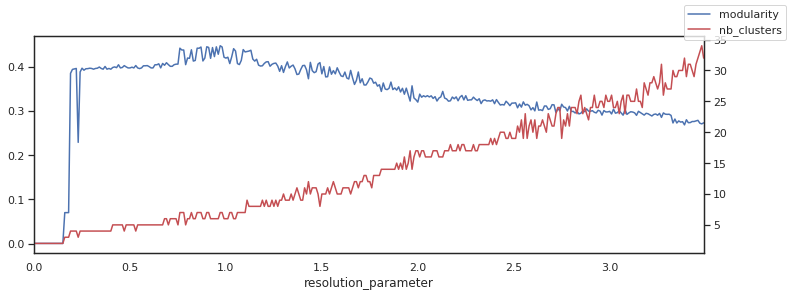

,resolution_parameter,modularity,nb_clusters
97,0.97,0.447345,7
90,0.90,0.445033,7
95,0.95,0.444919,6
98,0.98,0.444544,7
87,0.87,0.444436,7
91,0.91,0.443532,7
93,0.93,0.443254,6
85,0.85,0.441850,7
76,0.76,0.441850,7
86,0.86,0.441699,7


In [54]:
# builing the NLP-based patent network
model._build_patent_network()

..Nb of patents: 352


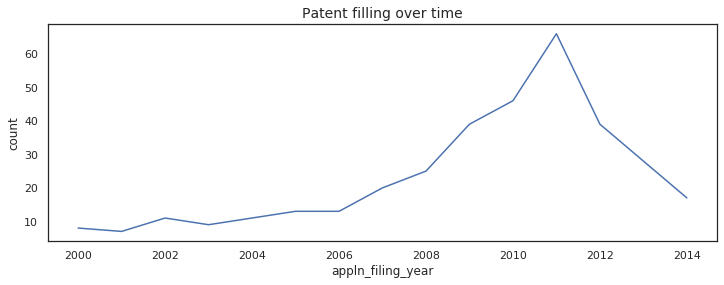

In [55]:
# show the summary statistics
model._display_summary_statistics()

Using the Louvain algorithm:


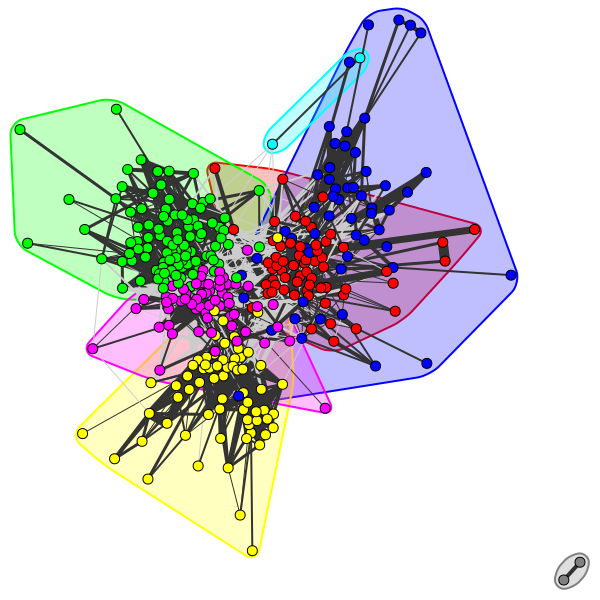

Using the Leiden algorithm, 2 iterations:


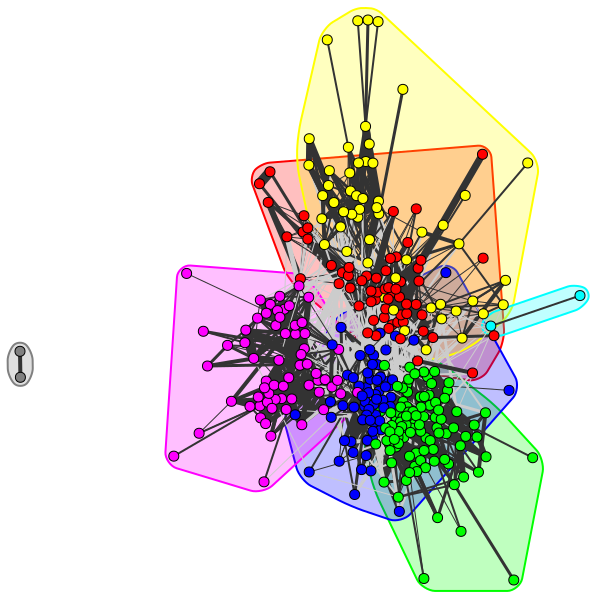

Using the Leiden algorithm, iterating until convergence:
This is the final model!


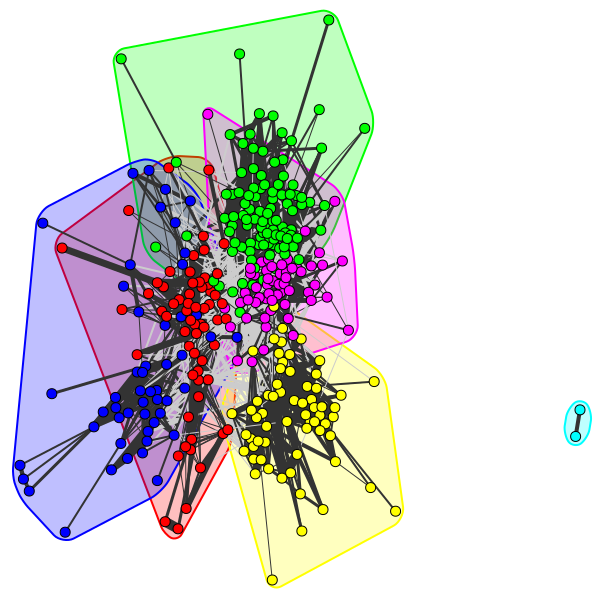

Cluster 0:


,freq_corpus,freq_cluster,squared_freq_cluster_div_freq_corpus
cool,5.386851,4.072883,3.079420
claim,42.417715,9.747994,2.240181
accord,35.574975,8.623315,2.090277
drive,5.029144,3.218596,2.059865
gear,3.681250,2.735484,2.032699
lock,2.964824,2.409858,1.958773
generat,20.224518,5.883000,1.711274
lift,4.598239,2.556247,1.421065
devic,10.931847,3.831069,1.342599
renew,2.817921,1.887673,1.264517


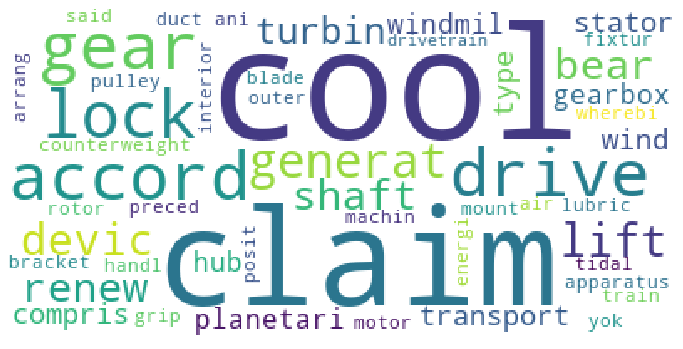

Cluster 1:


,freq_corpus,freq_cluster,squared_freq_cluster_div_freq_corpus
power,27.914032,16.209613,9.412884
wind,36.866834,13.990046,5.308874
control,19.240444,9.091098,4.295539
claim,42.417715,13.347732,4.200178
method,23.029510,9.571394,3.978009
said,20.807398,8.765721,3.692815
compris,21.201454,8.822690,3.671440
farm,8.117501,5.441151,3.647197
convert,7.160952,5.039385,3.546372
dc,4.667048,3.896374,3.252962


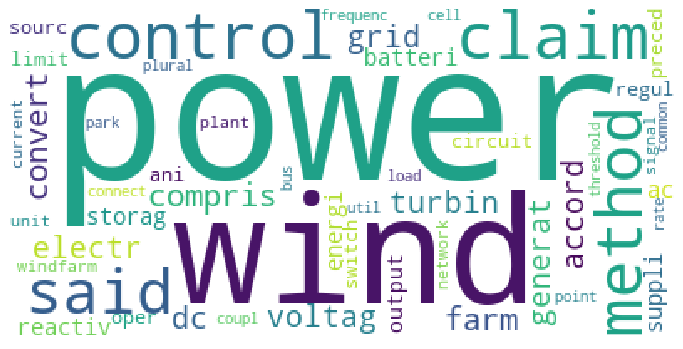

Cluster 2:


,freq_corpus,freq_cluster,squared_freq_cluster_div_freq_corpus
tower,9.479778,5.411534,3.089176
offshor,3.491476,2.759847,2.181528
structur,7.014194,3.634073,1.882823
claim,42.417715,7.925159,1.480705
concret,2.127688,1.735873,1.416210
mast,2.280069,1.789097,1.403846
foundat,2.413918,1.794297,1.333725
accord,35.574975,6.603897,1.225903
float,1.994742,1.535259,1.181616
bodi,3.583216,2.003971,1.120753


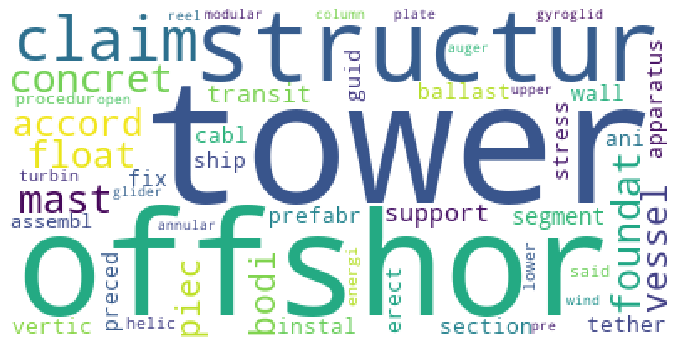

Cluster 3:


,freq_corpus,freq_cluster,squared_freq_cluster_div_freq_corpus
blade,23.112811,10.450496,4.725210
vortex,4.865480,3.634227,2.714554
claim,42.417715,10.549788,2.623857
turbin,31.655390,8.213281,2.131011
spar,2.979193,2.488401,2.078462
accord,35.574975,8.145142,1.864888
mould,2.276556,2.044578,1.836238
wind,36.866834,7.991823,1.732431
layer,2.751897,2.108350,1.615301
edg,4.355416,2.563739,1.509100


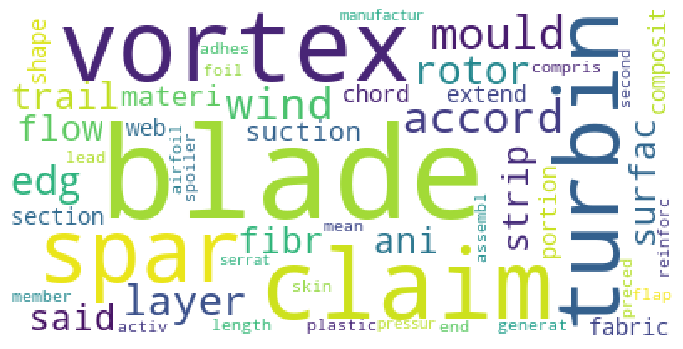

Cluster 4:


,freq_corpus,freq_cluster,squared_freq_cluster_div_freq_corpus
wind,36.866834,9.623860,2.512250
turbin,31.655390,7.708996,1.877362
sensor,4.538272,2.694013,1.599222
pitch,6.041554,2.971786,1.461795
speed,7.287032,3.199763,1.405028
method,23.029510,5.576164,1.350163
angl,4.636949,2.479086,1.325412
claim,42.417715,7.428551,1.300951
accord,35.574975,6.366087,1.139201
control,19.240444,4.560179,1.080808


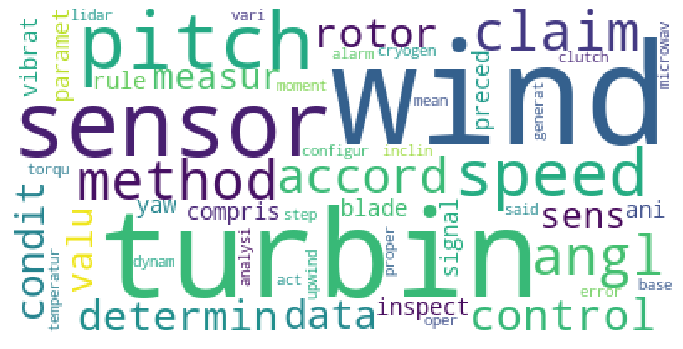

Cluster 5:


,freq_corpus,freq_cluster,squared_freq_cluster_div_freq_corpus
ic,0.704649,0.313257,0.139261
claim,42.417715,0.903213,0.019232
accord,35.574975,0.810345,0.018458
method,23.029510,0.630976,0.017288
rotor,14.622001,0.469885,0.015100
turbin,31.655390,0.600197,0.011380
wind,36.866834,0.600197,0.009771
blade,23.112811,0.469885,0.009553
heat,2.895683,0.156628,0.008472


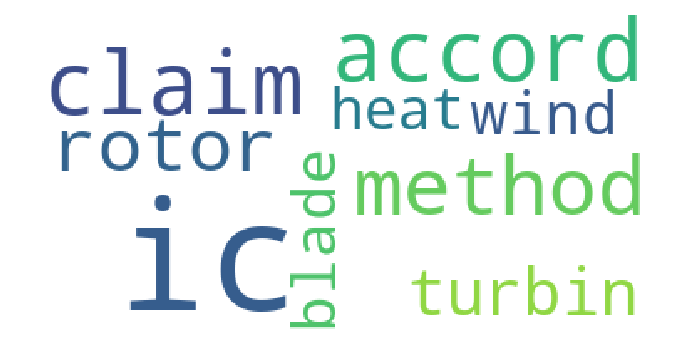

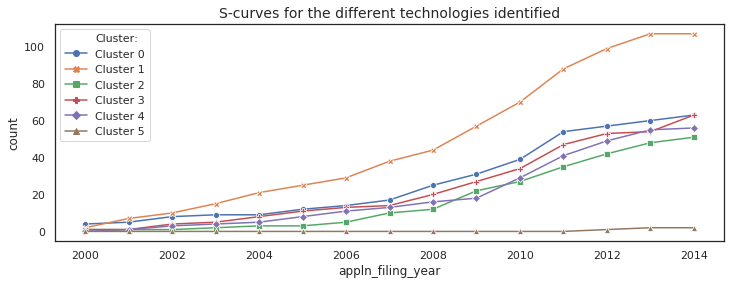

In [56]:
# plot a visualisation
model._visualise()

## 5. Concluding remarks

## References

* [1] https://igraph.org/r/doc/cluster_louvain.html
* [2] Traag, V. A., Waltman, L., & van Eck, N. J. (2019). From Louvain to Leiden: guaranteeing well-connected communities. Scientific reports, 9(1), 5233. http://dx.doi.org/10.1038/s41598-019-41695-z

## Annex 1 - The Leiden algorithm

*From https://igraph.org/c/doc/igraph-Community.html:*

The Leiden algorithm consists of three phases: (1) local moving of nodes, (2) refinement of the partition and (3) aggregation of the network based on the refined partition, using the non-refined partition to create an initial partition for the aggregate network. In the local move procedure in the Leiden algorithm, only nodes whose neighborhood has changed are visited. The refinement is done by restarting from a singleton partition within each cluster and gradually merging the subclusters. When aggregating, a single cluster may then be represented by several nodes (which are the subclusters identified in the refinement).

The Leiden algorithm provides several guarantees. The Leiden algorithm is typically iterated: the output of one iteration is used as the input for the next iteration. At each iteration all clusters are guaranteed to be connected and well-separated. After an iteration in which nothing has changed, all nodes and some parts are guaranteed to be locally optimally assigned. Finally, asymptotically, all subsets of all clusters are guaranteed to be locally optimally assigned. For more details, please see Traag, Waltman & van Eck (2019).

The objective function being optimized is:

> $1 / 2m sum_ij (A_{ij} - \gamma n_i n_j)d(s_i, s_j)$

where: 
- $m$ is the total edge weight, 
- $A_ij$ is the weight of edge $(i, j)$, 
- $\gamma$ is the so-called resolution parameter, 
- $n_i$ is the node weight of node $i$, 
- $s_i$ is the cluster of node $i$ and $d(x, y) = 1$ if and only if $x = y$ and $0$ otherwise. 

By setting $n_i = k_i$, the degree of node $i$, and dividing $\gamma$ by $2m$, you effectively obtain an expression for modularity. Hence, the standard modularity will be optimized when you supply the degrees as node_weights and by supplying as a resolution parameter $1.0/(2*m)$, with m the number of edges.